### Classifying Heart Disease - Logistic Regression Modeling in Python

Purpose: practice going through the machine learning pipeline, starting from examining the dataset itself to creating a polished classification model. Classification problems are much more common than regression problems, so it'll be good to get some practice.

Goal: This dataset comes from the famous Cleveland Clinic Foundation, which recorded information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual. This a prime example of how machine learning can help solve problems that have a real impact on people's lives.

Dataset: [Cleveland Clinic Foundation](https://archive.ics.uci.edu/dataset/45/heart+disease)
Source: UCI Machine Learning Repository

Note: the data is partially cleaned in advaned to perform binary classification. The original dataset has multiple classes, so you may download it from the site to attempt the guided project on multiple classes instead. For this project, we will focus on the binary classification case.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Load in the heart disease dataset
heart = pd.read_csv("heart_disease.csv")

### Exploring the Dataset
We should explore the dataset and perform any adjustments we might need before actually fitting the model. This may include converting categorical variables into dummy variables or centering and scaling variables. We'll also want to check for predictors that are distributed differently based on the outcome, since they could be informative for classification.

In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    object 
 13  thal        303 non-null    object 
 14  present     303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB


The `present` column is our binary outcome of interest. 0 - absence of heart disease. 1 - presence of heart disease

In [5]:
heart.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


array([[<Axes: title={'center': 'present'}>]], dtype=object)

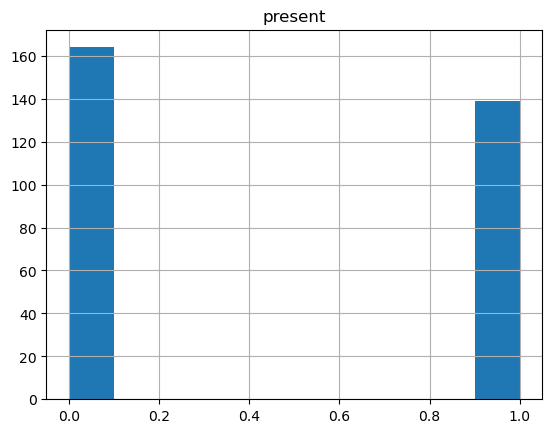

In [6]:
# Checking the outcome
heart.hist("present")

In [8]:
#convert column's 'ca' and 'tha1' to float type so it can be aggregated

# changing object to flaot for further analysis
heart = heart[heart['ca'] != '?']
heart = heart[heart['thal'] != '?']

heart['ca'] = heart['ca'].astype(float)
heart['thal'] = heart['thal'].astype(float)

There's almost an equal number of cases and non-cases in the dataset.

We have to contend with the issue of feature selection since it won't be clear ahead of time which variables will produce the best classification model.

One strategy in linear regression is to use visualizations to determine if there were high correlations between a predictor and the outcome. We also use visualizations to make this judgment for binary variables. We'll do something similar here. 

Feature Selection via Split-Apply-Combine

We are interested in which predictors are meaningfully different when comparing between the 0 and 1 classes. For example, if the range and distribution of horsepower for low-price cars is significantly different from high-price cars, then horsepower can be a useful predictor to include in a model because it distinguishes cases from non-cases. We might go through each predictor and repeatedly calculate its means among the 0 and 1 classes. This can get repetitive and is error-prone. Another way to do this quickly is to take advantage of the groupby() and agg() methods that are available for pandas DataFrames.

This workflow is what we refer to as split-apply-combine, and it is a powerful and quick way to understand the data. There are several methods for writing this workflow for pandas — we've chosen this method because it allows us to summarize multiple columns at once, which is what we'll want for feature selection.

In [9]:
# We'll also want to check for predictors that are distributed differently based on the outcome, since they could be informative for classification.
# Checking potential predictors

heart.groupby("present").agg(
    {
        "age": "mean",
        "sex": "mean",
        "cp": "mean",
        "trestbps": "mean",
        "chol": "mean",
        "fbs": "mean",
        "restecg": "mean",
        "thalach": "mean",
        "exang": "mean",
        "oldpeak": "mean",
        "slope": "mean",
        "ca": "mean",
        "thal": "mean"
    }
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.643750,0.556250,2.793750,129.175000,243.493750,0.143750,0.843750,158.581250,0.143750,0.598750,1.412500,0.275000,3.787500
1,56.759124,0.817518,3.583942,134.635036,251.854015,0.145985,1.175182,139.109489,0.540146,1.589051,1.824818,1.145985,5.832117


Some columns have a small, but noticeable difference when stratified by predictors. Based on the differences and some knowledge about heart disease, these seem like good candidates for predictors:

1. `age`
2. `thalach` (maximum heart rate achieved)
3. `restecg` (resting ECG)
4. `ca` (number of vessels colored by fluoroscopy)

### Dividing the Data

We'll use a 70-30 split of the dataset for the training and test sets.

In [10]:
X = heart[["age", "thalach", "restecg", "ca"]]
y = heart["present"]

# 70% for training set, 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [11]:
# Checking for separation in the datasets
print("Y_train_0: ", sum(y_train == 0))
print("Y_train_1: ", sum(y_train == 1))
print("Y_test_0: ", sum(y_test == 0))
print("Y_test_1: ", sum(y_test == 1))

Y_train_0:  109
Y_train_1:  98
Y_test_0:  51
Y_test_1:  39


We confirm above that there are both cases and non-cases in both the training and test sets

### Build the Model

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

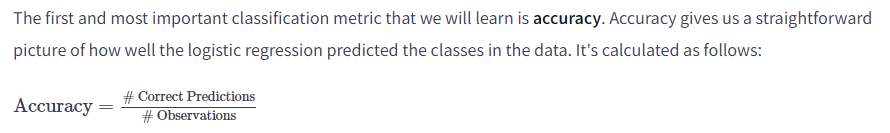

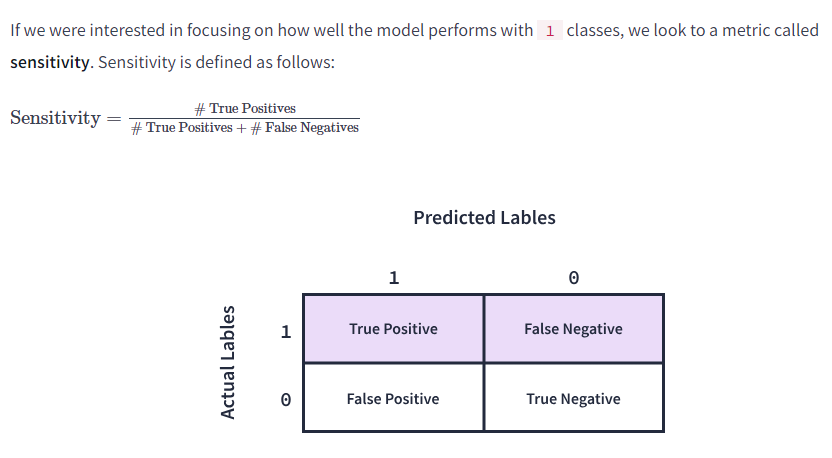

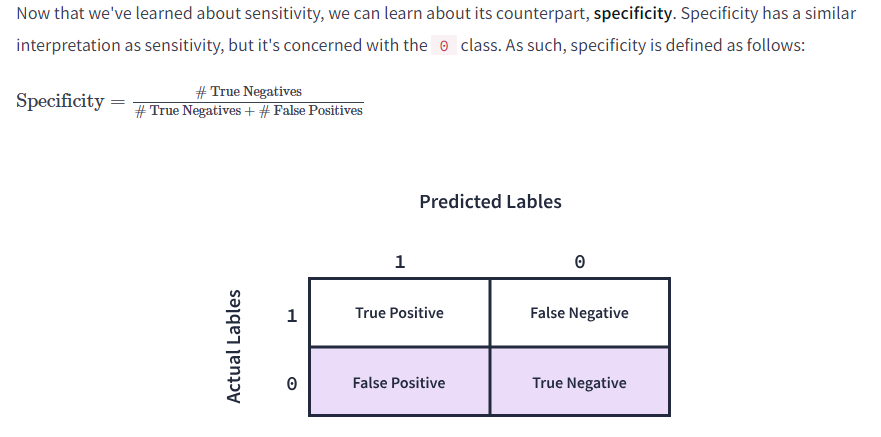

In [13]:
# Checking the various metrics for the model
acc = model.score(X_train, y_train)

predictions = model.predict(X_train)

#true positive
tp = sum((predictions == 1) & (y_train == 1))
#false positive
fp = sum((predictions == 1) & (y_train == 0))
#true negative
tn = sum((predictions == 0) & (y_train == 0))
#false negative
fn = sum((predictions == 0) & (y_train == 1))

#sensitivity
sens = tp / (tp + fn)

#specificty
spec = tn / (tn + fp)

print("Training Accuracy: ", acc)
print("Training Sensitivity: ", sens)
print("Training Specificity: ", spec)
     

Training Accuracy:  0.7681159420289855
Training Sensitivity:  0.6632653061224489
Training Specificity:  0.8623853211009175


Overall the training accuracy was about 76%, the sensitivity was 66%, and the specificity was 86%. Based on these metrics, the model seems to perform better for non-cases.

### Interpreting the Model Coefficients

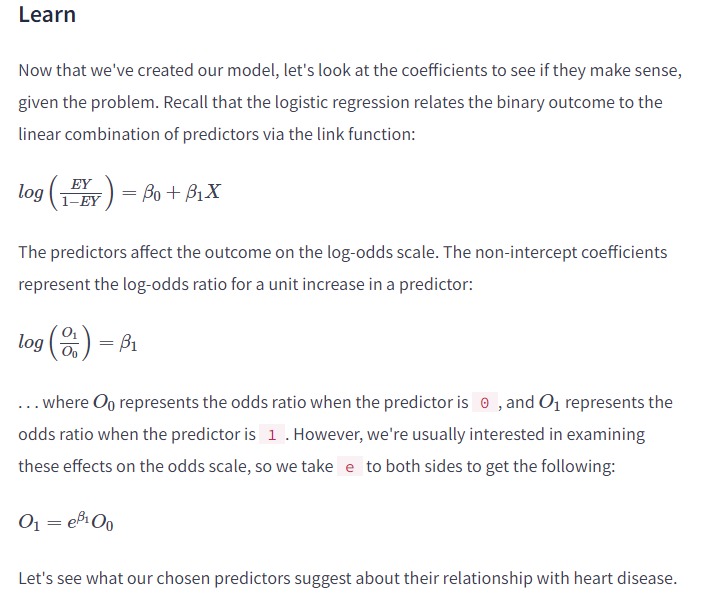

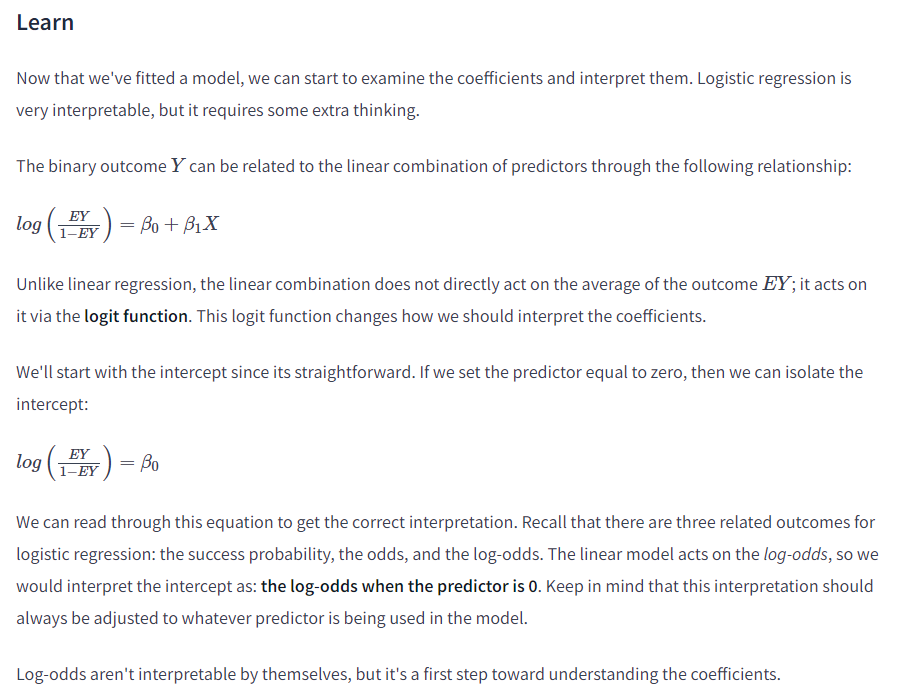
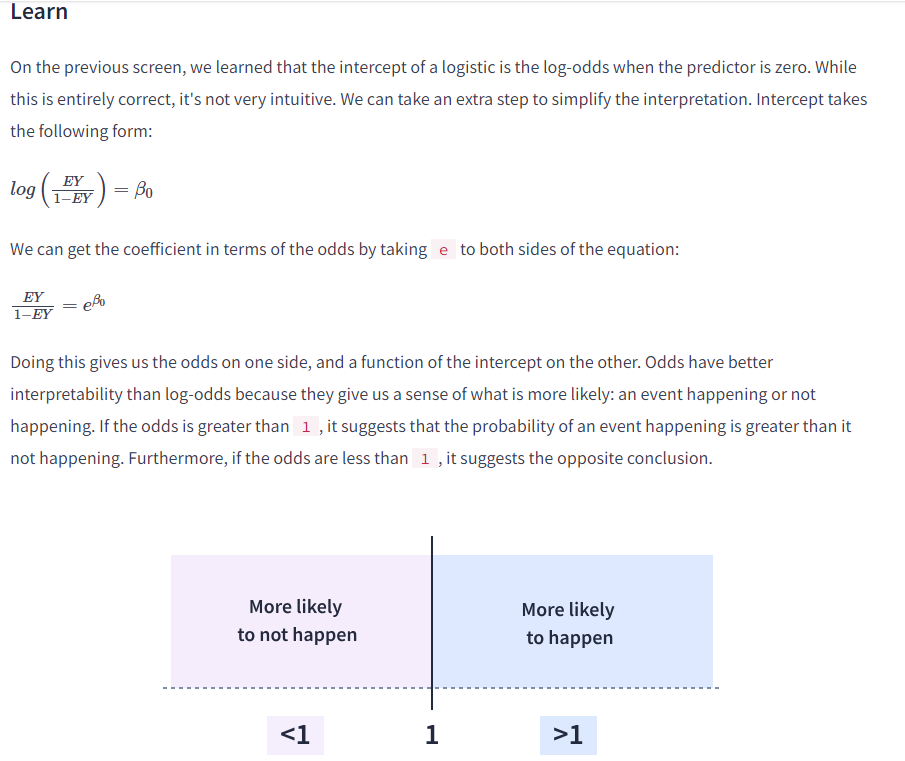
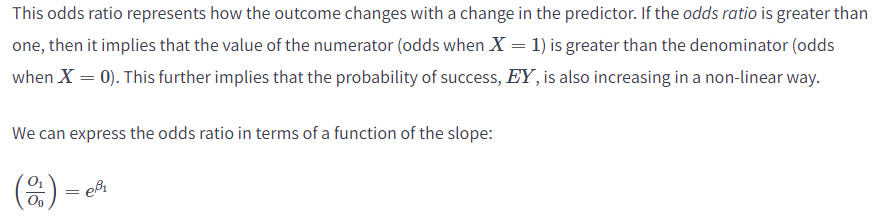

In [14]:
coefs = ["age", "thalach", "restecg", "ca"]

# Checking in terms of log-odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(val, 2))

age : -0.02
thalach : -0.04
restecg : 0.39
ca : 1.18


In [15]:

# Checking in terms of odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(np.exp(val), 2))
     

age : 0.98
thalach : 0.96
restecg : 1.47
ca : 3.25


- Higher age and maximum heart rate (thalach) is associated with lower odds of heart disease holding the other predictors constant, but both of these odds ratios are close to 1.
- Resting ECG and the number of colored vessels are associated with higher odds of heart disease holding the other predictors constant. These increases seem to be moderate and high, respectively  (a 47% increase and 225% (!) increase).

### Final Model Evaluation

In [16]:
# Checking the various metrics for the model (test set)
acc = model.score(X_test, y_test)

predictions = model.predict(X_test)
tp = sum((predictions == 1) & (y_test == 1))
fp = sum((predictions == 1) & (y_test == 0))
tn = sum((predictions == 0) & (y_test == 0))
fn = sum((predictions == 0) & (y_test == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)

Test Accuracy:  0.7555555555555555
Test Sensitivity:  0.7948717948717948
Test Specificity:  0.7254901960784313


### Drawing Conclusions

Test accuracy was 75%, sensitivity was 79%, and specificity was 72%. Compared to the training set, the accuracy didn't change much, while the model fared better with cases and worse with non-cases. This is potentially useful since this application is health-based. We might be more interested in being better at identifying cases than non-cases.